In [38]:
import diff_gaussian_rasterization
import torch
import numpy as np
import pyquaternion
import os
import math
import matplotlib.pyplot as plt

In [66]:
device = torch.device("cuda")

# generate a random point cloud
N = 10
means3D = torch.cat(
    [
        torch.rand(N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.zeros(N, 1, dtype=torch.float32, device=device)+1,
    ],
    dim=1,
)
means2D = torch.zeros(N, 2, dtype=torch.float32, device=device)
opacities = torch.ones(N, 1, dtype=torch.float32, device=device)
scales = torch.ones(N, 3, dtype=torch.float32, device=device) * 0.1
rotations = (
    torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
    .to(torch.float32)
    .to(device)
)
colors_precomp = torch.rand(N, 3, dtype=torch.float32, device=device)

In [41]:
means3D

tensor([[-0.9378,  0.2865,  0.3000],
        [ 0.9977, -0.8661,  0.3000],
        [-0.9646, -0.1585,  0.3000],
        [-0.9199, -0.5528,  0.3000],
        [-0.4630, -0.7576,  0.3000],
        [ 0.6394,  0.9599,  0.3000],
        [ 0.6856,  0.9293,  0.3000],
        [ 0.6190,  0.6571,  0.3000],
        [-0.8966,  0.2678,  0.3000],
        [-0.7062,  0.1927,  0.3000]], device='cuda:0')

In [42]:
# generate the projection matrix (orthographic)

def gen_orthographic_matrix(left: float, right: float, bottom: float, top: float, near: float, far: float):
    """Generate orthographic projection matrix.

    Args:
        left (float): left plane
        right (float): right plane
        bottom (float): bottom plane
        top (float): top plane
        near (float): near plane
        far (float): far plane

    Returns:
        torch.Tensor: orthographic projection matrix
    """
    return torch.tensor([
        [2 / (right - left), 0, 0, -(right + left) / (right - left)],
        [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
        [0, 0, -2 / (far - near), -(far + near) / (far - near)],
        [0, 0, 0, 1],
    ])

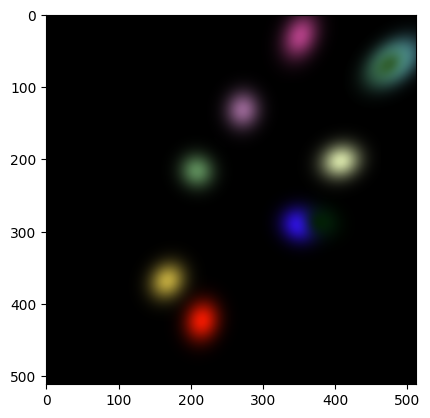

In [69]:
FoVx = 90
FoVy = 90

raster_settings = diff_gaussian_rasterization.GaussianRasterizationSettings(
    image_height=512,
    image_width=512,
    tanfovx=math.tan(FoVx * 0.5),
    tanfovy=math.tan(FoVy * 0.5),
    bg=torch.zeros(4, dtype=torch.float32, device=device),
    scale_modifier=1.0,
    viewmatrix=torch.eye(4, dtype=torch.float32, device=device),
    projmatrix=gen_orthographic_matrix(-1, 1, -1, 1, -1, 1).to(device),
    sh_degree=1,
    campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
    prefiltered=False,
    debug=True,
)

rasterizer = diff_gaussian_rasterization.GaussianRasterizer(raster_settings=raster_settings)

rendered_image, radii = rasterizer(
    means3D=means3D,
    means2D=means2D,
    colors_precomp=colors_precomp,
    opacities=opacities,
    scales=scales,
    rotations=rotations,
)


# display the rendered image
plt.imshow(rendered_image.permute(1, 2, 0).cpu().numpy())